# Важно

*Данный блокнот нужен лишь для визуализации процесса обучения модели, при попытке запуска данного блокнота вне Google Colaboratory некоторые важные функции не будут работать*

Результаты обучения сохраняются в удаленной директории https://drive.google.com/drive/u/1/folders/1_NoihxVVlRLWrg2ITqUT8zafuJpZFGgo в виде .h5 файла весов. Доступ к этим весам далее может быть получен с помощью функции lesa.models.utils.get_remote_weights_path.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/mikhail-moro/lesa.git
!cp -a /content/lesa/models/. /content/
!pip install livelossplot

Cloning into 'lesa'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 137 (delta 34), reused 130 (delta 30), pack-reused 0
Receiving objects: 100% (137/137), 543.20 KiB | 4.68 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [3]:
import os
import datetime

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from benchmark import Benchmark
from models import build_unet_plus_plus
from utils import PlotLossesCallback, save_weights_remote


IMAGE_SIZE = 256
BATCH_SIZE = 32

AUTOTUNE = tf.data.AUTOTUNE
DATASETS_DIR = "/content/drive/MyDrive/datasets"

# Данные

In [4]:
#@markdown Датасет
dataset_name = "auto" # @param {type:"string"}

if dataset_name == "auto":
    files_data = {}

    for dt in os.listdir(DATASETS_DIR):
        metadata_dir = os.path.join(DATASETS_DIR, dt, 'metadata.csv')

        if os.path.exists(metadata_dir):
            files_data[os.path.join(DATASETS_DIR, dt)] = datetime.datetime.strptime(
                pd.read_csv(metadata_dir)["time_create"][0],
                "%d-%m-%Y %H:%M"
            )

    DATASET_PATH = max(files_data, key=files_data.get) # Получаем последний созданный датасет
else:
    DATASET_PATH = dataset_name

dataset_metadata = pd.read_csv(os.path.join(DATASET_PATH, 'metadata.csv'))

dataset_metadata

train_files          val_files       time_create
0  file 1.tfrecords  file 10.tfrecords  09-08-2023 17:23
1  file 2.tfrecords                NaN               NaN
2  file 3.tfrecords                NaN               NaN
3  file 4.tfrecords                NaN               NaN
4  file 5.tfrecords                NaN               NaN
5  file 6.tfrecords                NaN               NaN
6  file 7.tfrecords                NaN               NaN
7  file 8.tfrecords                NaN               NaN
8  file 9.tfrecords                NaN               NaN

In [5]:
!mkdir dataset
!cp -a "$DATASET_PATH/." /content/dataset/

In [6]:
rescaling_layer = tf.keras.layers.Rescaling(1./255)

feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "mask": tf.io.FixedLenFeature([], tf.string)
}


@tf.function
def parse_tfrecord_fn(example):
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.ensure_shape(tf.io.decode_jpeg(example["image"], channels=3), (IMAGE_SIZE, IMAGE_SIZE, 3))
    example["mask"] = tf.ensure_shape(tf.io.decode_jpeg(example["mask"], channels=1), (IMAGE_SIZE, IMAGE_SIZE, 1))
    return example

@tf.function
def prepare_tfrecord_fn(example):
    return rescaling_layer(example["image"]), rescaling_layer(example["mask"])


train_dataset = (
    tf.data.TFRecordDataset(
        [os.path.join("/content/dataset", fl) for fl in dataset_metadata["train_files"].dropna()],
        num_parallel_reads=AUTOTUNE
    )
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(prepare_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .shuffle(BATCH_SIZE*10)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

val_dataset = (
    tf.data.TFRecordDataset(
        [os.path.join("/content/dataset", fl) for fl in dataset_metadata["val_files"].dropna()],
        num_parallel_reads=AUTOTUNE
    )
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(prepare_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .shuffle(BATCH_SIZE*10)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
);

# Модель

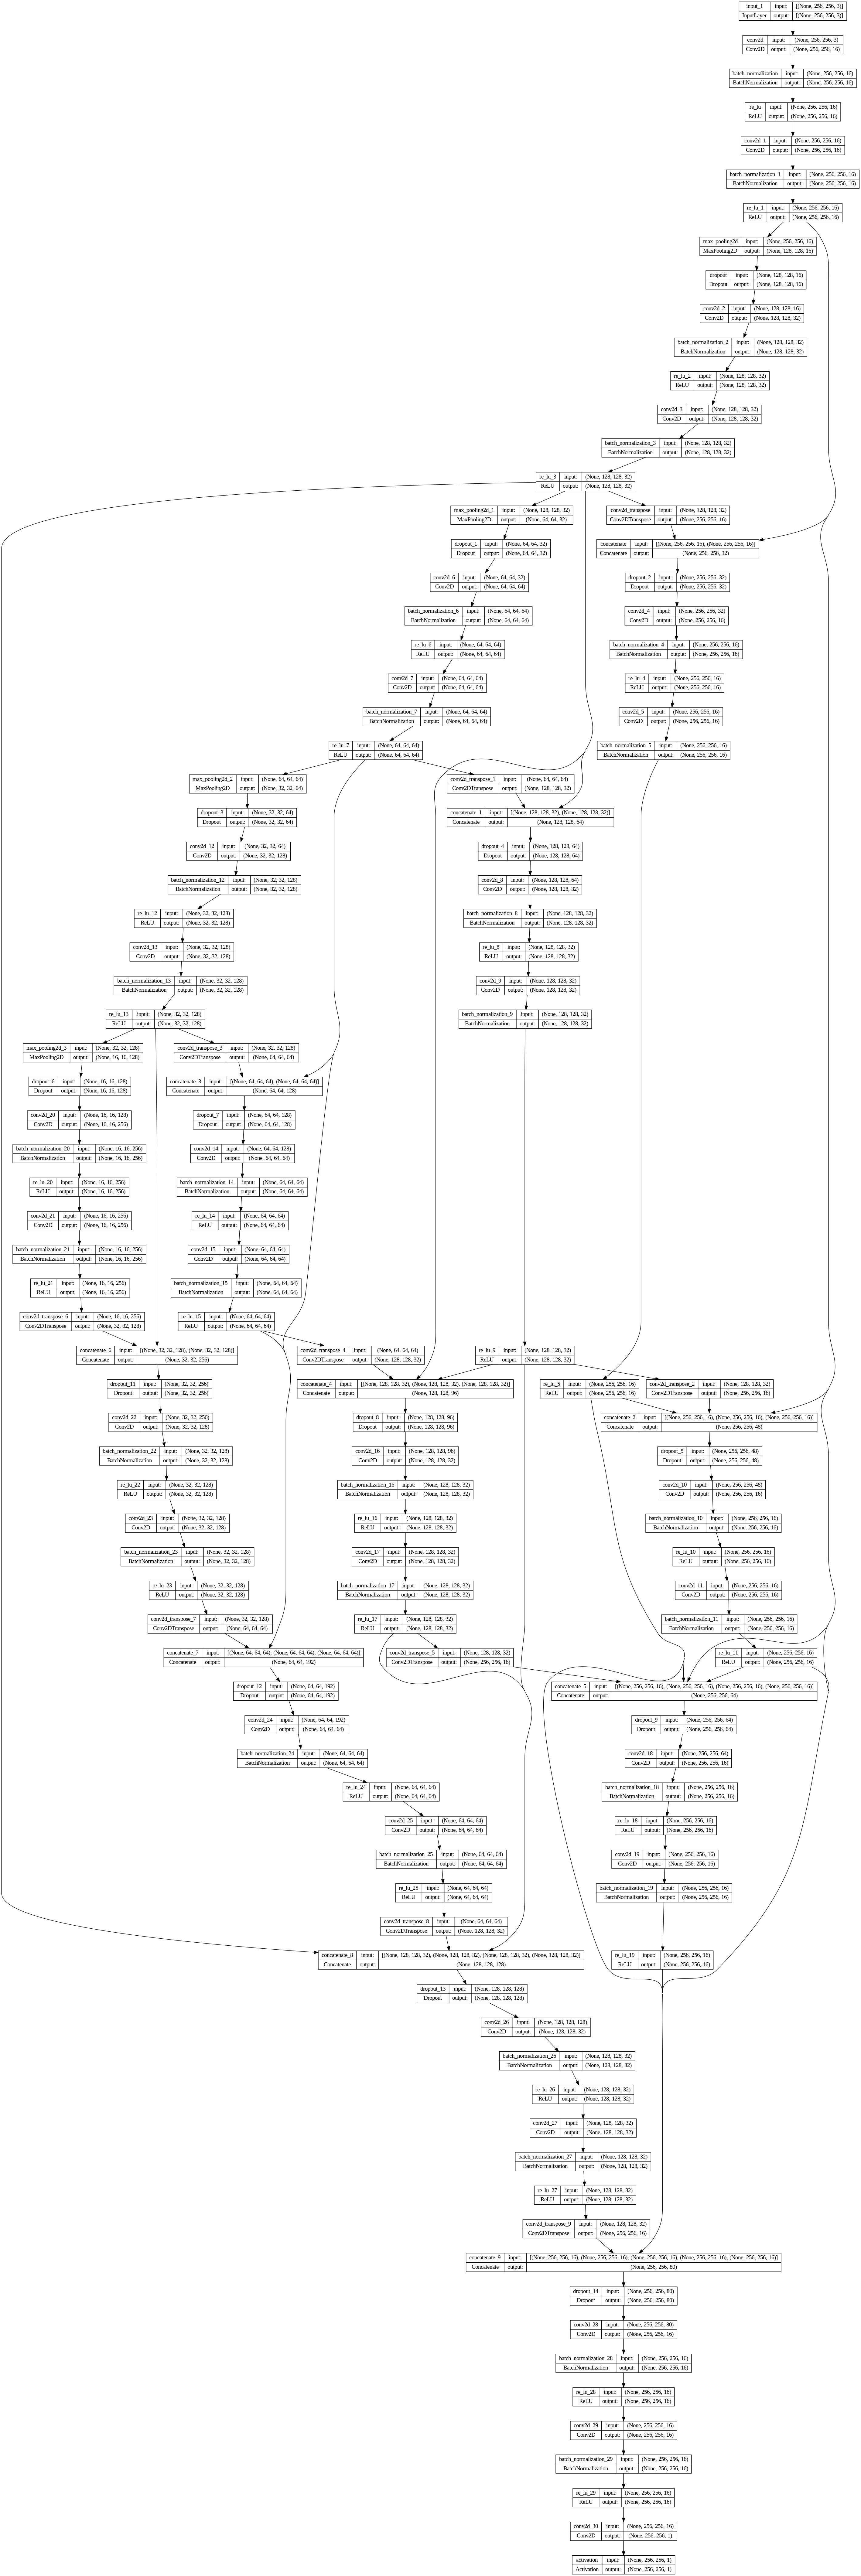

In [7]:
model = build_unet_plus_plus()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryIoU(),
        'accuracy'
    ]
)

tf.keras.utils.plot_model(
    model,
    show_shapes = True
)

# Обучение

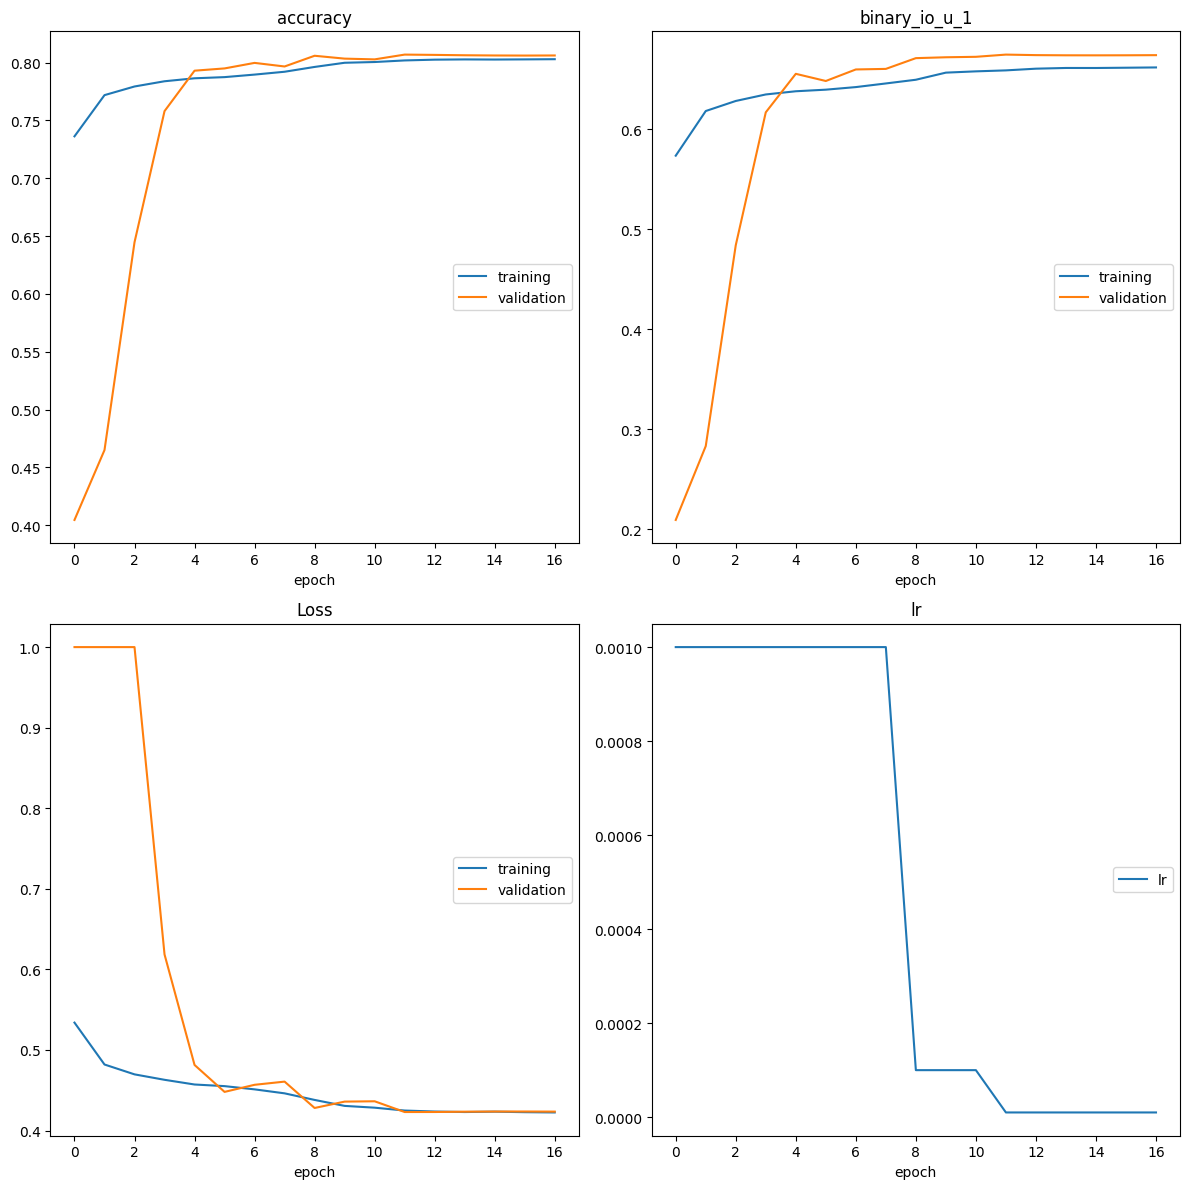

accuracy
	training         	 (min:    0.736, max:    0.803, cur:    0.803)
	validation       	 (min:    0.405, max:    0.807, cur:    0.806)
binary_io_u_1
	training         	 (min:    0.573, max:    0.662, cur:    0.662)
	validation       	 (min:    0.209, max:    0.674, cur:    0.674)
Loss
	training         	 (min:    0.422, max:    0.534, cur:    0.422)
	validation       	 (min:    0.423, max:    1.000, cur:    0.423)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
144/144 [==============================] - 199s 1s/step - loss: 0.4224 - binary_io_u_1: 0.6615 - accuracy: 0.8030 - val_loss: 0.4235 - val_binary_io_u_1: 0.6738 - val_accuracy: 0.8062 - lr: 1.0000e-05
Epoch 17: early stopping


In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    PlotLossesCallback(clip=(0, 1))
]

history = model.fit(
    x=train_dataset,
    batch_size=BATCH_SIZE,
    epochs=25,
    validation_data=val_dataset,
    callbacks=callbacks
)

In [9]:
save_weights_remote(model);

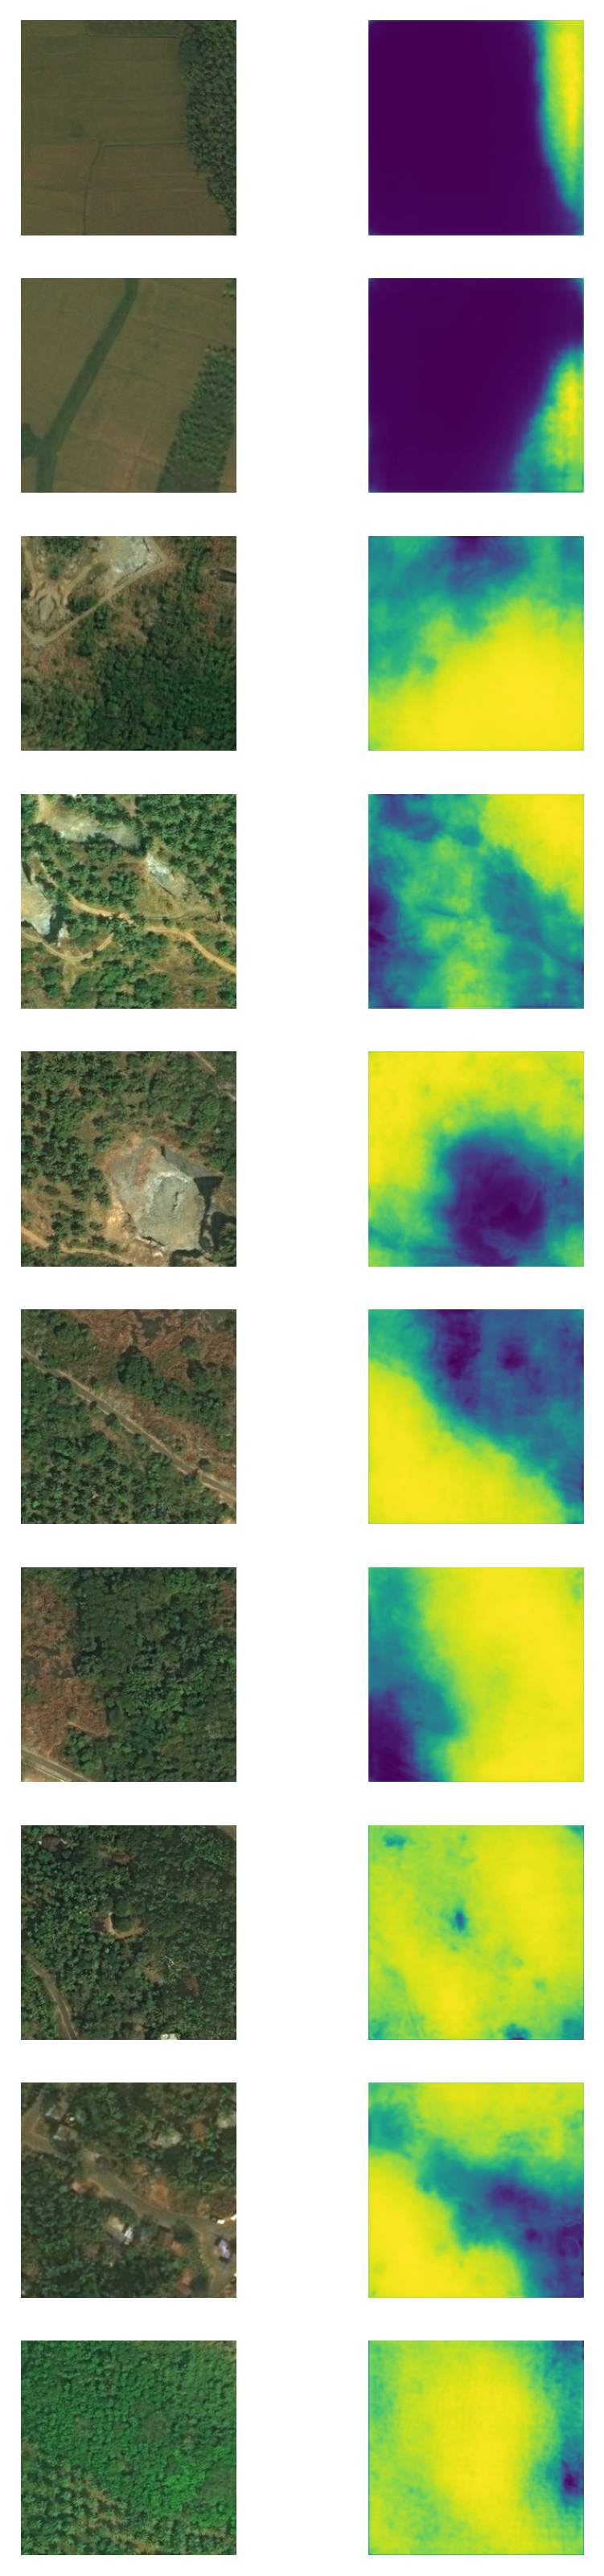

In [10]:
examples = 10

test_dataset = (
    tf.data.TFRecordDataset(
        [os.path.join("/content/dataset", fl) for fl in dataset_metadata["train_files"].dropna()],
        num_parallel_reads=AUTOTUNE
    )
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)


fig = plt.figure(figsize=(4, 16), dpi=256)
ax_mat = fig.subplots(nrows=examples, ncols=2)
ax = ax_mat.flatten()
lst = list(test_dataset.take(10))


for i, l in zip(range(0, examples*2, 2), lst):
    example = rescaling_layer(l["image"])
    predicted = model.predict(np.array([example]), verbose=0)[0]

    ax[i].imshow(example)
    ax[i].set_axis_off()

    ax[i+1].imshow(predicted)
    ax[i+1].set_axis_off()


fig.show();

# Проверка на фото Ростова со спутника

In [11]:
benchmark = Benchmark(
    save_for_visualising=True,
    images_path="/content/benchmark_data/images",
    masks_path="/content/benchmark_data/masks"
)

test_data = benchmark.compute(model)
images_data = benchmark.get_images_data()

pd.DataFrame(test_data.items())

0         1
0     mean_binary_io_u  0.606186
1  zoom_16_binary_io_u  0.584378
2  zoom_17_binary_io_u  0.659972
3  zoom_18_binary_io_u  0.574206

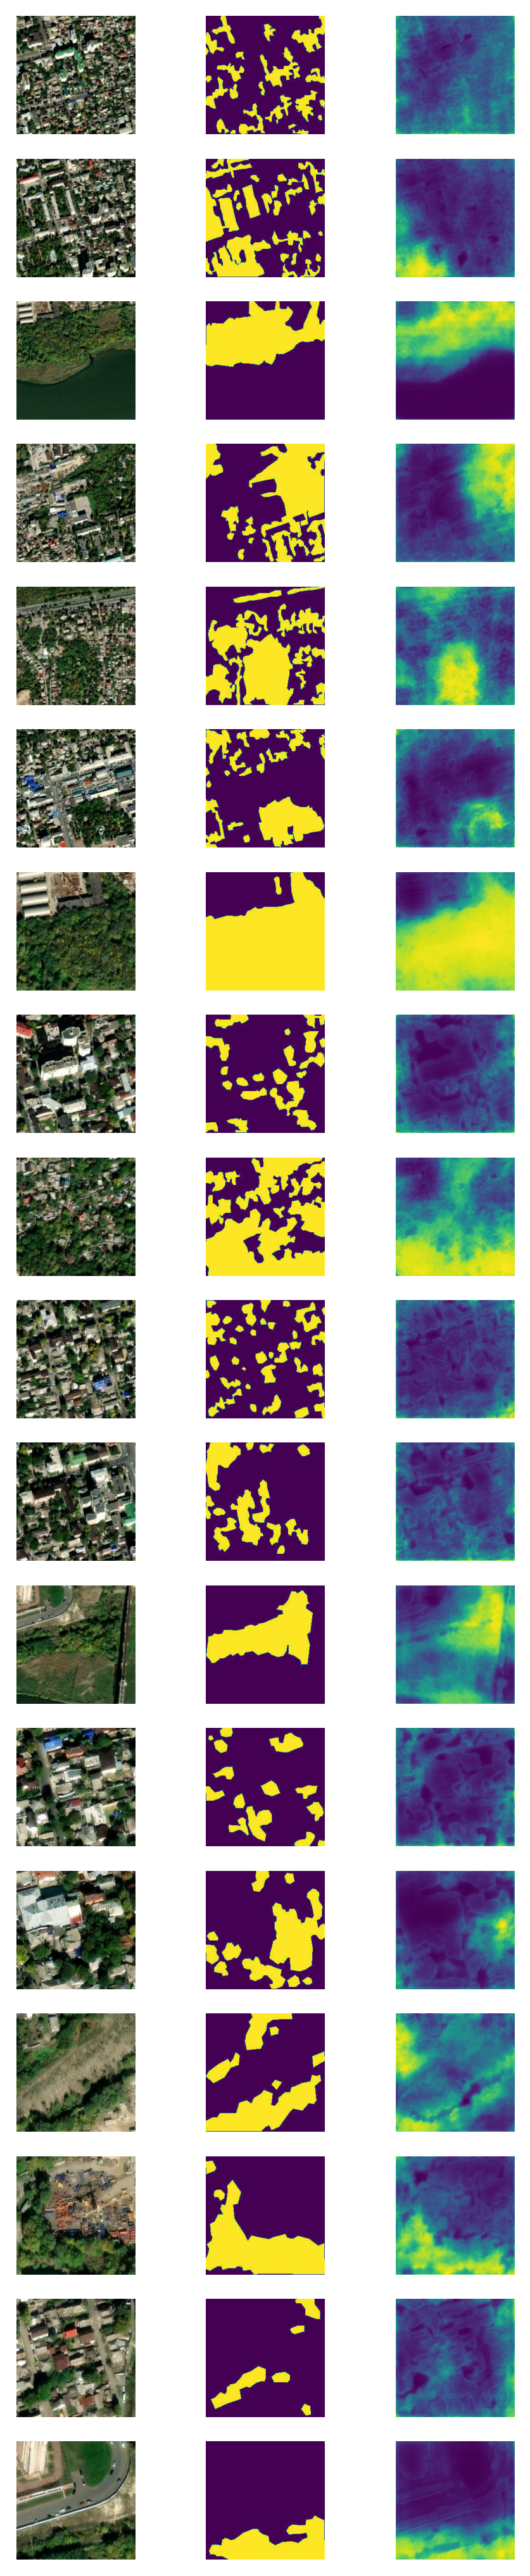

In [12]:
fig, axis = plt.subplots(nrows=18, ncols=3)

for ax, orig, true, pred in zip(axis, images_data["original_images"], images_data["true_masks"], images_data["pred_masks"]):
    ax[0].imshow(orig)
    ax[0].set_axis_off()

    ax[1].imshow(true)
    ax[1].set_axis_off()

    ax[2].imshow(pred)
    ax[2].set_axis_off()

fig.set_dpi(256)
fig.set_size_inches(4, 16)
fig.tight_layout()

plt.show();